<a href="https://colab.research.google.com/github/asmith1138/MachineTranslation/blob/main/MT_eng_deu_transformer_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q tensorflow_datasets
!pip install -q tensorflow_text

     |████████████████████████████████| 3.4MB 12.8MB/s 


In [3]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow as tf

In [4]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

In [5]:
#config = tfds.translate.wmt.WmtConfig(
#    version="0.0.1",
#    language_pair=("de", "en"),
#    subsets={
#        tfds.Split.TRAIN: ["commoncrawl_frde"],
#        tfds.Split.VALIDATION: ["euelections_dev2019"],
#    },
#)
#builder = tfds.builder("wmt_translate", config=config)
examplesDe, metadataDe = tfds.load('para_crawl/ende_plain_text', with_info=True, as_supervised=True)
#print(examplesDe.keys())
train_examples = examplesDe['train']#, examplesDe['validation']
print(train_examples)
#tf.data.experimental.save(
#    train_examplesDe, '/content/drive/MyDrive/MT/para_crawl_ds/para_crawl', compression=None, shard_func=None
#)

#builder.download_and_prepare(download_dir='wmt_translate', download_config=config)
#trainDE_examples, valDE_examples = builder['train'], builder['validation']
#examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)
#train_examples, val_examples = examples['train'], examples['validation']


Shuffling and writing examples to /root/tensorflow_datasets/para_crawl/ende_plain_text/1.0.0.incompleteASJP02/para_crawl-train.tfrecord


Dataset para_crawl downloaded and prepared to /root/tensorflow_datasets/para_crawl/ende_plain_text/1.0.0. Subsequent calls will reuse this data.
<PrefetchDataset shapes: ((), ()), types: (tf.string, tf.string)>


In [6]:
for de_examples, en_examples in train_examples.batch(3).take(1):
  for de in de_examples.numpy():
    print(de.decode('utf-8'))

  print()

  for en in en_examples.numpy():
    print(en.decode('utf-8'))

print(train_examples)
train_examplesDe = train_examples.take(100000)
test_examplesDe = train_examples.skip(100000).take(3000)
print(tuple(train_examplesDe.take(1)))
print(tuple(test_examplesDe.take(1)))

Pictures of Quebec : roofs of Quebec
April 2007 In a not-so-shocking yet extremely relevant survey, BtoBonline discovered that most email marketers - especially those on the business to business side - continue to forgo testing their campaigns before they actually send them.
"Chekists can see nothing beyond their own noses [...] they are degenerating into ordinary nincompoops, and [...] they don't want to fulfill the directive of the Central Committee." (p. 134)

Fotos von Quebec - Dächer von Quebec
April 2007 In einer nicht so schockierenden, aber sehr relevanten Umfrage, entdeckte BtoBonline das die meisten E-Mail Vermarkter – besonders die auf der business to business Seite- verzichten weiterhin auf die Prüfung Ihrer Kampagnen bevor sie Sie senden.
Tschekisten können nicht über ihre eigene Nase hinausblicken [...], sie sind dabei, in gewöhnliche Schlafmützen zu degenerieren und [...] sie wollen nicht die Direktiven des ZK erfüllen. (S. 134)
<PrefetchDataset shapes: ((), ()), types: 

## Text tokenization & detokenization

You can't train a model directly on text. The text needs to be converted to some numeric representation first. Typically, you convert the text to sequences of token IDs, which are as indexes into an embedding.

One popular implementation is demonstrated in the [Subword tokenizer tutorial](https://www.tensorflow.org/tutorials/tensorflow_text/subwords_tokenizer) builds subword tokenizers (`text.BertTokenizer`) optimized for this dataset and exports them in a [saved_model](https://www.tensorflow.org/guide/saved_model). 

Download and unzip and import the `saved_model`:

In [7]:
#model_name = "ted_hrlr_translate_pt_en_converter"
#tf.keras.utils.get_file(
#    f"{model_name}.zip",
#    f"https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip",
#    cache_dir='.', cache_subdir='', extract=True
#)

#!pip install transformers
#from transformers import pipeline
#unmasker = pipeline('fill-mask', model='bert-base-multilingual-cased')
#unmasker("Hello I'm a [MASK] model.")

#from transformers import BertTokenizer, TFBertModel
#tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
#bertmodel = TFBertModel.from_pretrained("bert-base-multilingual-cased")
#text = "Ich bin studentin"
#encoded_input = tokenizer(text, return_tensors='tf')
#output = bertmodel(encoded_input)
#print("******************************")
#print(tokenizer)
#print(encoded_input)
#print(output)


model_nameDe = "/content/drive/MyDrive/MT/paracrawl_de_en_converter"
tf.keras.utils.get_file(
    f"{model_nameDe}.zip",
    f"file://{model_nameDe}.zip",
    cache_dir='.', cache_subdir='', extract=True
)
#wmt19_translate_de_en_converter

'/content/drive/MyDrive/MT/paracrawl_de_en_converter.zip'

In [8]:
tokenizers = tf.saved_model.load(model_nameDe)

In [9]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [10]:
for en in en_examples.numpy():
  print(en.decode('utf-8'))

Fotos von Quebec - Dächer von Quebec
April 2007 In einer nicht so schockierenden, aber sehr relevanten Umfrage, entdeckte BtoBonline das die meisten E-Mail Vermarkter – besonders die auf der business to business Seite- verzichten weiterhin auf die Prüfung Ihrer Kampagnen bevor sie Sie senden.
Tschekisten können nicht über ihre eigene Nase hinausblicken [...], sie sind dabei, in gewöhnliche Schlafmützen zu degenerieren und [...] sie wollen nicht die Direktiven des ZK erfüllen. (S. 134)


In [11]:
encoded = tokenizers.en.tokenize(en_examples)

for row in encoded.to_list():
  print(row)

[2, 1453, 991, 58, 1594, 1296, 1107, 16, 6101, 1018, 991, 58, 1594, 1296, 1107, 3]
[2, 1501, 1578, 990, 1030, 1011, 1050, 60, 1190, 3957, 5245, 15, 1049, 1077, 59, 1177, 993, 1799, 1965, 1026, 3960, 15, 4991, 993, 43, 2123, 3678, 1002, 2924, 998, 988, 1463, 46, 16, 1543, 63, 1018, 2562, 1018, 368, 1438, 988, 1003, 989, 3185, 2755, 3185, 1195, 16, 63, 1018, 5969, 2352, 2302, 1003, 988, 2873, 1104, 5974, 1002, 1810, 992, 992, 2436, 17, 3]
[2, 61, 1895, 2399, 1206, 1042, 1011, 1029, 1046, 1906, 55, 2272, 1851, 2713, 995, 36, 17, 17, 17, 38, 15, 992, 1015, 1297, 15, 990, 48, 993, 4120, 993, 60, 1190, 1586, 1129, 1047, 4642, 996, 1233, 1218, 4912, 1234, 987, 36, 17, 17, 17, 38, 992, 1375, 1011, 988, 1314, 2103, 1004, 67, 1109, 3054, 17, 11, 60, 17, 1316, 1257, 12, 3]


The `detokenize` method attempts to convert these token IDs back to human readable text: 

In [12]:
round_trip = tokenizers.en.detokenize(encoded)
for line in round_trip.numpy():
  print(line.decode('utf-8'))

fotos von quebec - dacher von quebec
april 2007 in einer nicht so schockierenden , aber sehr relevanten umfrage , entdeckte btobonline das die meisten e - mail vermarkter – besonders die auf der business to business seite - verzichten weiterhin auf die prufung ihrer kampagnen bevor sie sie senden .
tschekisten konnen nicht uber ihre eigene nase hinausblicken [ . . . ] , sie sind dabei , in gewohnliche schlafmutzen zu degenerieren und [ . . . ] sie wollen nicht die direktiven des zk erfullen . ( s . 134 )


The lower level `lookup` method converts from token-IDs to token text:

In [13]:
tokens = tokenizers.en.lookup(encoded)
tokens

<tf.RaggedTensor [[b'[START]', b'fotos', b'von', b'q', b'##ue', b'##be', b'##c', b'-', b'dach', b'##er', b'von', b'q', b'##ue', b'##be', b'##c', b'[END]'], [b'[START]', b'april', b'2007', b'in', b'einer', b'nicht', b'so', b's', b'##ch', b'##ock', b'##ierenden', b',', b'aber', b'sehr', b'r', b'##el', b'##e', b'##va', b'##nten', b'um', b'##frage', b',', b'entdeckt', b'##e', b'b', b'##to', b'##bo', b'##n', b'##line', b'das', b'die', b'meisten', b'e', b'-', b'mail', b'v', b'##er', b'##markt', b'##er', b'\xe2\x80\x93', b'besonders', b'die', b'auf', b'der', b'business', b'to', b'business', b'seite', b'-', b'v', b'##er', b'##zi', b'##chten', b'weiterhin', b'auf', b'die', b'prufung', b'ihrer', b'kampagne', b'##n', b'bevor', b'sie', b'sie', b'senden', b'.', b'[END]'], [b'[START]', b't', b'##sche', b'##ki', b'##sten', b'konnen', b'nicht', b'uber', b'ihre', b'eigene', b'n', b'##ase', b'hinaus', b'##blick', b'##en', b'[', b'.', b'.', b'.', b']', b',', b'sie', b'sind', b'dabei', b',', b'in', b'g', 

Here you can see the "subword" aspect of the tokenizers. The word "searchability" is decomposed into "search ##ability" and the word "serindipity" into "s ##ere ##nd ##ip ##ity"

## Setup input pipeline

To build an input pipeline suitable for training you'll apply some transformations to the dataset.

This function will be used to encode the batches of raw text:

In [14]:
def tokenize_pairs(de, en):
    de = tokenizers.de.tokenize(de)
    # Convert from ragged to dense, padding with zeros.
    de = de.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()
    return de, en

In [15]:
#def tokenize_pairs(de, en):
#    de = tokenizers.pt.tokenize(de)
#    # Convert from ragged to dense, padding with zeros.
#    de = de.to_tensor()
#    de_enc = tokenizer(de, return_tensors='tf')
#    en_enc = tokenizer(en, return_tensors='tf')
#    en = tokenizers.en.tokenize(en)
#    # Convert from ragged to dense, padding with zeros.
#    en = en.to_tensor()
#    return de_enc, en_enc

Here's a simple input pipeline that processes, shuffles and batches the data:

In [16]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [17]:
def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE))

print(train_examplesDe)
train_batches = make_batches(train_examplesDe)
#val_batches = make_batches(val_examples)

<TakeDataset shapes: ((), ()), types: (tf.string, tf.string)>


## Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

In [18]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [19]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 2048, 512)


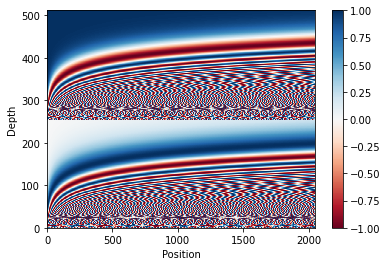

In [20]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

## Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value `0` is present: it outputs a `1` at those locations, and a `0` otherwise.

In [21]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [22]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.

In [23]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [24]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Scaled dot product attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k\left(\frac{QK^T}{\sqrt{d_k}}\right) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. So the *square root of `dk`* is used for scaling, so you get a consistent variance regardless of the value of `dk`. If the variance is too low the output may be too flat to optimize effectively. If the variance is too high the softmax may saturate at initilization making it dificult to learn. 

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [25]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.

In [26]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print('Attention weights are:')
  print(temp_attn)
  print('Output is:')
  print(temp_out)

In [27]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [28]:
# This query aligns with a repeated key (third and fourth),
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [29]:
# This query aligns equally with the first and second key,
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


Pass all the queries together.

In [30]:
temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [31]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

Create a `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

In [32]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [33]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [34]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder and decoder

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

The transformer model follows the same general pattern as a standard [sequence to sequence with attention model](nmt_with_attention.ipynb). 

* The input sentence is passed through `N` encoder layers that generates an output for each word/token in the sequence.
* The decoder attends on the encoder's output and its own input (self-attention) to predict the next word. 

### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [35]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [36]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [37]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [38]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [39]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            self.d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

In [40]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### Decoder

 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [41]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [42]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Create the Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [43]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.tokenizer = Encoder(num_layers, d_model, num_heads, dff,
                             input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inp, tar, training, enc_padding_mask,
           look_ahead_mask, dec_padding_mask):

    enc_output = self.tokenizer(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

In [44]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                               enc_padding_mask=None,
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## Set hyperparameters

To keep this example small and relatively fast, the values for *num_layers, d_model, and dff* have been reduced. 

The values used in the base model of transformer were; *num_layers=6*, *d_model = 512*, *dff = 2048*. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

Note: By changing the values below, you can get the model that achieved state of the art on many tasks.

In [45]:
num_layers = 6
d_model = 512
dff = 2048
num_heads = 8
dropout_rate = 0.1

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$


In [46]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [47]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

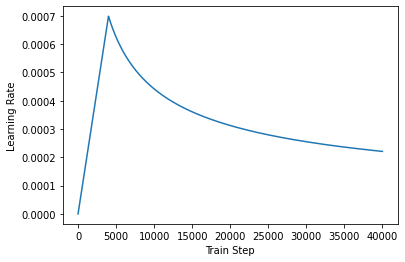

In [48]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [49]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [50]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [51]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

## Training and checkpointing

In [52]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.de.get_vocab_size(),
    target_vocab_size=tokenizers.en.get_vocab_size(),
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [53]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)

  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

  return enc_padding_mask, combined_mask, dec_padding_mask

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [54]:
checkpoint_path = "/content/drive/MyDrive/MT/checkpointsPaper/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. `tar_real` is that same input shifted by 1: At each location in `tar_input`, `tar_real` contains the  next token that should be predicted.

For example, `sentence` = "SOS A lion in the jungle is sleeping EOS"

`tar_inp` =  "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next. 

During training this example uses teacher-forcing (like in the [text generation tutorial](./text_generation.ipynb)). Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, *self-attention* allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peeking at the expected output the model uses a look-ahead mask.

In [55]:
EPOCHS = 50

In [56]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp,
                                 True,
                                 enc_padding_mask,
                                 combined_mask,
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

Portuguese is used as the input language and English is the target language.

In [57]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> German, tar -> english
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 9.0112 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.7560 Accuracy 0.0241
Epoch 1 Batch 100 Loss 8.5266 Accuracy 0.0317
Epoch 1 Batch 150 Loss 8.3283 Accuracy 0.0365
Epoch 1 Batch 200 Loss 8.1210 Accuracy 0.0411
Epoch 1 Batch 250 Loss 7.9124 Accuracy 0.0481
Epoch 1 Batch 300 Loss 7.7413 Accuracy 0.0535
Epoch 1 Batch 350 Loss 7.6079 Accuracy 0.0581
Epoch 1 Batch 400 Loss 7.5053 Accuracy 0.0616
Epoch 1 Batch 450 Loss 7.4214 Accuracy 0.0647
Epoch 1 Batch 500 Loss 7.3492 Accuracy 0.0677
Epoch 1 Batch 550 Loss 7.2817 Accuracy 0.0706
Epoch 1 Batch 600 Loss 7.2192 Accuracy 0.0729
Epoch 1 Batch 650 Loss 7.1567 Accuracy 0.0752
Epoch 1 Batch 700 Loss 7.0951 Accuracy 0.0774
Epoch 1 Batch 750 Loss 7.0360 Accuracy 0.0795
Epoch 1 Batch 800 Loss 6.9807 Accuracy 0.0815
Epoch 1 Batch 850 Loss 6.9290 Accuracy 0.0832
Epoch 1 Batch 900 Loss 6.8798 Accuracy 0.0849
Epoch 1 Batch 950 Loss 6.8333 Accuracy 0.0864
Epoch 1 Batch 1000 Loss 6.7895 Accuracy 0.0879
Epoch 1 Batch 1050 Loss 6.7482 Accur

## Evaluate

The following steps are used for evaluation:

* Encode the input sentence using the Portuguese tokenizer (`tokenizers.pt`). This is the encoder input.
* The decoder input is initialized to the `[START]` token.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* The model makes predictions of the next word for each word in the output. Most of these are redundant. Use the predictions from the last word.
* Concatenate the predicted word to the decoder input and pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

Note: The model used here has less capacity to keep the example relatively faster so the predictions maybe less right. To reproduce the results in the paper, use the entire dataset and base transformer model or transformer XL, by changing the hyperparameters above.

In [58]:
def evaluate(sentence, max_length=40):
  # inp sentence is portuguese, hence adding the start and end token
  sentence = tf.convert_to_tensor([sentence])
  sentence = tokenizers.de.tokenize(sentence).to_tensor()

  encoder_input = sentence

  # as the target is english, the first word to the transformer should be the
  # english start token.
  start, end = tokenizers.en.tokenize([''])[0]
  output = tf.convert_to_tensor([start])
  output = tf.expand_dims(output, 0)

  for i in range(max_length):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)

    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input,
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.argmax(predictions, axis=-1)

    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

    # return the result if the predicted_id is equal to the end token
    if predicted_id == end:
      break

  # output.shape (1, tokens)
  text = tokenizers.en.detokenize(output)[0]  # shape: ()

  tokens = tokenizers.en.lookup(output)[0]

  return text, tokens, attention_weights

In [59]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [60]:
#sentence = "Dies ist ein Problem, das wir lösen müssen."
#ground_truth = "this is a problem we have to solve ."
ground_truth = "Dies ist ein Problem, das wir lösen müssen."
sentence = "this is a problem we have to solve ."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : this is a problem we have to solve .
Prediction     : dies ist ein problem , um zu sammeln .
Ground truth   : Dies ist ein Problem, das wir lösen müssen.


In [61]:
#sentence = "und meine Nachbarhäuser hörten von dieser Idee."
#ground_truth = "and my neighboring homes heard about this idea ."
ground_truth = "und meine Nachbarhäuser hörten von dieser Idee."
sentence = "and my neighboring homes heard about this idea ."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : and my neighboring homes heard about this idea .
Prediction     : „ ich habe hier auch einige fotos gelernt .
Ground truth   : und meine Nachbarhäuser hörten von dieser Idee.


In [62]:
#sentence = "Deshalb werde ich Ihnen sehr schnell einige Geschichten über einige magische Dinge erzählen, die passiert sind."
#ground_truth = "so i \'ll just share with you some stories very quickly of some magical things that have happened ."
ground_truth = "Deshalb werde ich Ihnen sehr schnell einige Geschichten über einige magische Dinge erzählen, die passiert sind."
sentence = "so i'll just share with you some stories very quickly of some magical things that have happened ."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : so i'll just share with you some stories very quickly of some magical things that have happened .
Prediction     : ich weiss es aber , dass viele menschen mit ihren songs spielen .
Ground truth   : Deshalb werde ich Ihnen sehr schnell einige Geschichten über einige magische Dinge erzählen, die passiert sind.


You can pass different layers and attention blocks of the decoder to the `plot` parameter.

## Attention plots

The `evaluate` function also returns a dictionary of attention maps you can use to visualize the internal working of the model:

In [63]:
#sentence = "Dies ist das erste Buch, das ich jemals gemacht habe."
#ground_truth = "this is the first book i've ever done."
ground_truth = "Dies ist das erste Buch, das ich jemals gemacht habe."
sentence = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : this is the first book i've ever done.
Prediction     : dies ist das erste mal , das ich mal unter der herrschaft abgeschrieben habe .
Ground truth   : Dies ist das erste Buch, das ich jemals gemacht habe.


In [64]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The plot is of the attention when a token was generated.
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [65]:
head = 0
# shape: (batch=1, num_heads, seq_len_q, seq_len_k)
attention_heads = tf.squeeze(
  attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]
attention.shape

TensorShape([19, 13])

In [66]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.de.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.de.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(13,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'the', b'first', b'book', b'i', b"'",
       b've', b'ever', b'done', b'.', b'[END]'], dtype=object)>

In [67]:
translated_tokens

<tf.Tensor: shape=(20,), dtype=string, numpy=
array([b'[START]', b'dies', b'ist', b'das', b'erste', b'mal', b',',
       b'das', b'ich', b'mal', b'unter', b'der', b'herr', b'##schaft',
       b'ab', b'##ges', b'##chrieben', b'habe', b'.', b'[END]'],
      dtype=object)>

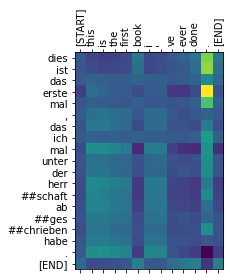

In [68]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [69]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.de.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.de.lookup(in_tokens)[0]
  in_tokens

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

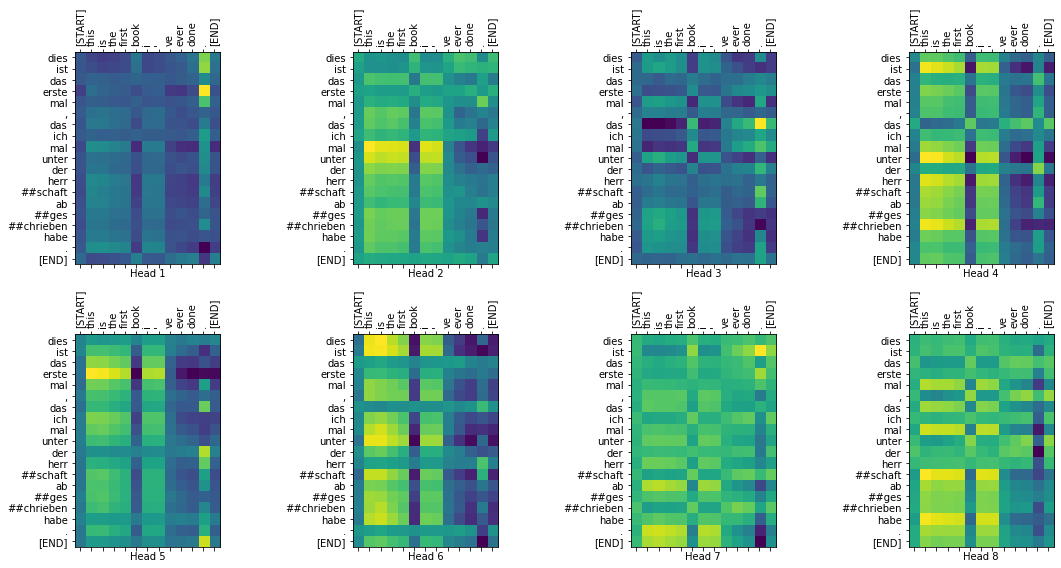

In [70]:
plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

The model does okay on unfamiliar words. Neither "triceratops" or "encyclopedia" are in the input dataset and the model almost learns to transliterate them, even without a shared vocabulary:

Input:         : I read about triceratops in the encyclopedia.
Prediction     : ich bat diesen artikel in chile .
Ground truth   : Ich habe in der Enzyklopädie über Triceratops gelesen.


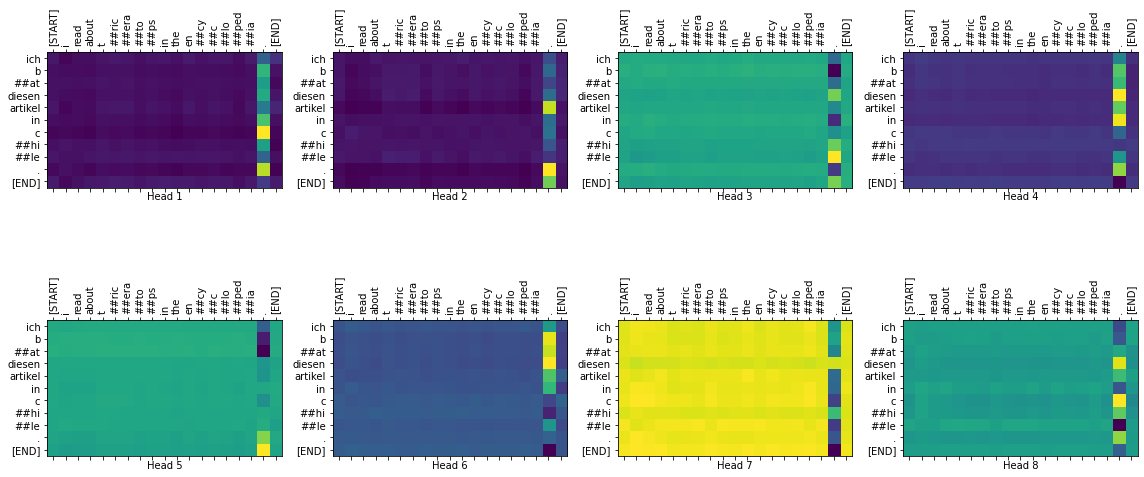

In [71]:
#sentence = "Ich habe in der Enzyklopädie über Triceratops gelesen."
#ground_truth = "I read about triceratops in the encyclopedia."
ground_truth = "Ich habe in der Enzyklopädie über Triceratops gelesen."
sentence = "I read about triceratops in the encyclopedia."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

## Summary

In this tutorial, you learned about positional encoding, multi-head attention, the importance of masking and how to create a transformer.

Try using a different dataset to train the transformer. You can also create the base transformer or transformer XL by changing the hyperparameters above. You can also use the layers defined here to create [BERT](https://arxiv.org/abs/1810.04805) and train state of the art models. Furthermore, you can implement beam search to get better predictions.

In [75]:
# evaluate the skill of the model
from nltk.translate.bleu_score import corpus_bleu

def evaluate_model():
  actual, predicted = list(), list()
  for i, source in enumerate(test_examplesDe):
    eng, deu = source
    #print('i=[%s], eng=[%s], deu=[%s]' % (i,eng,deu))
    engStr = eng.numpy().decode('UTF-8') 
    #print(engStr)
    translated_text, translated_tokens, attention_weights = evaluate(engStr)
    predStr = translated_text.numpy().decode('UTF-8') 
    #print(predStr)
    deuStr = deu.numpy().decode('UTF-8')
    actual.append(deuStr)
    predicted.append(predStr)
    if (i % 500) == 0:
      print('i=[%s], eng=[%s]' % (i,engStr))
      print('i=[%s], deu=[%s]' % (i,deuStr))
      print('i=[%s], pred=[%s]' % (i,predStr))
      print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
      print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
      print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
      print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
  print("Final scores")
  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
  print('BLEU: %f' % corpus_bleu(actual, predicted))
  
evaluate_model()
  
  
  
  #actual, predicted = list(), list()
	#for i, source in enumerate(sources):
		# translate encoded source text
	#	source = source.reshape((1, source.shape[0]))
	#	translation = predict_sequence(model, eng_tokenizer, source)
	#	raw_target, raw_src = raw_dataset[i]
	#	if i < 10:
	#		print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
	#	actual.append([raw_target.split()])
	#	predicted.append(translation.split())
	# calculate BLEU score
	#print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	#print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	#print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	#print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))




i=[0], eng=[Welcome gift for children up to six years with a T-shirt from "Snow White and the 7 Dwarfs"]
i=[0], deu=[Willkommensgeschenk für Kinder bis sechs Jahre mit einem T-Shirt von "Schneewittchen und den 7 Zwergen"]
i=[0], pred=[„ blattern mit tollen kindern – dieses mal fur 10 jahre und alter ! “ - sagt marie florida .]
BLEU-1: 0.206522
BLEU-2: 0.454447
BLEU-3: 0.623002
BLEU-4: 0.674127


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


i=[500], eng=[These statutory rights are not curtailed by the warranty.]
i=[500], deu=[Diese gesetzlichen Rechte werden durch die Garantie nicht eingeschränkt.]
i=[500], pred=[diese art von schuldnell ohne schuldige schuld keine wunsche .]
BLEU-1: 0.188056
BLEU-2: 0.433654
BLEU-3: 0.605740
BLEU-4: 0.658524
i=[1000], eng=[Request here your reservation for the holiday-home holiday home "Allod Park C401"]
i=[1000], deu=[Stellen Sie hier Ihre Reservierungsanfrage für Ferienhaus "Allod Park C401"]
i=[1000], pred=[stellen sie hier ihre reservierungsanfrage fur ferienhaus " residence "]
BLEU-1: 0.188573
BLEU-2: 0.434250
BLEU-3: 0.606239
BLEU-4: 0.658977
i=[1500], eng=[Such encounters are very rare because the Lebanese blame the Palestinians for triggering their civil war, and the Palestinians have bitter memories of their own suffering during those days.]
i=[1500], deu=[Solche Begegnungen seien sehr selten, da die Libanesen die Palästinenser beschuldigen, den Bürgerkrieg ausgelöst zu haben un